# **Table of Contents**
* [Data Wrangling](#section_21)<br><br>
* [Discovering Clusters](#section_2)
    * [Finding best 'K'](#section_3)
    * [Using best 'K'](#section_4)
    * [Cluster labelling](#section_5)
    * [Viewing Clusters](#section_6)<br><br>
* [Inference from Clusters](#section_7)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import warnings
warnings.filterwarnings("ignore")

import time
import datetime as dt

In [2]:
df  =  pd.read_excel ("datasets/Online Retail.xlsx")

df.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
198251,554026,22316,200 BENDY SKULL STRAWS,192,2011-05-20 13:34:00,1.06,13324.0,United Kingdom
470400,576617,85179A,GREEN BITTY LIGHT CHAIN,1,2011-11-15 16:57:00,2.46,NaN,United Kingdom
74807,542527,22988,SOLDIERS EGG CUP,24,2011-01-28 12:48:00,1.25,17188.0,United Kingdom


<a id='section_21'></a>
# **1 - Data Wrangling**

As customer clusters may vary by geography, I’ll restrict the data to only United Kingdom customers, which contains most of our customers historical data.

In [3]:
uk  =  df [ df['Country']=='United Kingdom' ]

In [4]:
# Remove Canceled Orders

uk  =  uk [ uk['Quantity']>0 ]

In [5]:
# Remove rows where customerID is NA

uk.dropna ( subset=['CustomerID'] , how='all' , inplace=True)

In [6]:
# Restrict the data to one full year because it's better to use a metric per Months or Years in RFM

uk  =  uk [ uk['InvoiceDate'] >=  "2010-12-09" ]

## **1.1 - Creating RFM matrix**

## **1.1.1 - Recency**

To calculate recency, we need to choose a date point from which we evaluate **how many days ago was the customer's last purchase**.

In [7]:
# last date available in our dataset

uk ['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

The last date we have is 2011-12-09 so we will use it as reference.

In [8]:
now = dt.date(2011,12,9)

print(now)

2011-12-09


In [9]:
# Create a new column called date which contains the date of invoice only

uk['date']  =  uk['InvoiceDate'].dt.date

In [10]:
# Group by customers and check last date of purchase

r_df  =  uk.groupby (by='CustomerID', as_index=False) ['date'].max()

r_df.columns = ['CustomerID','LastPurchaseDate']

r_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [11]:
# Calculate recency
r_df ['Recency']     =   r_df ['LastPurchaseDate'].apply (lambda x: (now - x).days)


# Drop LastPurchaseDate
r_df.drop ('LastPurchaseDate' , axis=1 , inplace=True)

In [12]:
r_df.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


## **1.1.2 - Frequency**

Frequency helps us to know **how many times a customer purchased from us**. To do that we need to check how many invoices are registered by the same customer.

In [13]:
# drop duplicates

uk_copy = uk
uk_copy.drop_duplicates ( subset=['InvoiceNo', 'CustomerID'] , keep="first" , inplace=True )

In [14]:
# Calculate frequency of purchases

f_df  =  uk_copy.groupby ( by=['CustomerID'] , as_index=False)     ['InvoiceNo'].count()

f_df.columns = ['CustomerID','Frequency']

f_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


## **1.1.3 - Monetary**

Monetary attribute answers the question: **How much money did the customer spent over time?**

To do that, first, we will create a new column total cost to have the total price per invoice.

In [15]:
# Create TotalCost Column

uk ['TotalCost']  =  uk['Quantity'] * uk['UnitPrice']

In [16]:
m_df  =  uk.groupby ( by='CustomerID' , as_index=False)    .agg ({'TotalCost': 'sum'})

m_df.columns = ['CustomerID','Monetary']

m_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


## **1.2 - Merging**

In [17]:
temp_df  =  r_df.merge   (f_df , on='CustomerID')

rfm_df   = temp_df.merge (m_df , on='CustomerID')

rfm_df.drop ('CustomerID' , axis=1 , inplace =True)

rfm_df.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,2,10,658.89
2,0,196,3739.23
3,3,5,98.35
4,3,4,58.20


## **1.3 - Transform**

In [18]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()

In [19]:
df = pd.DataFrame ( pt.fit_transform(rfm_df)  ,  columns = list(rfm_df.columns) )

df.head(3)

,Recency,Frequency,Monetary
0,1.682373,-1.148472,3.614781
1,-1.735475,1.489108,1.637693
2,-2.225068,2.348818,2.476262


## **1.4 - Feature Selection via PCA**

In [20]:
from sklearn.decomposition import PCA

pca  =  PCA ()                     

pca.fit (df)
    
print  ( pca.explained_variance_ratio_ )

[0.69704622 0.22051142 0.08244236]


In [21]:
pca  =  PCA ( n_components = 2 )                               #   % explained variance

df   =  pca.fit_transform(df)

df   =  pd.DataFrame(df)

<a id='section_2'></a>
# **2 - Discovering Clusters** 

<a id='section_3'></a>
## **2.1 - Finding Best K**

### **2.1.1 - Pairplot**

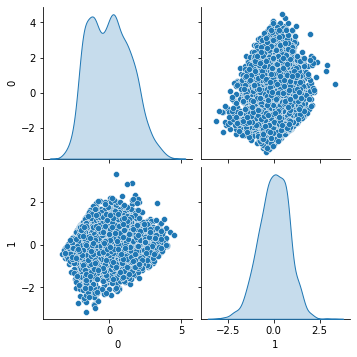

In [22]:
sns.pairplot ( df , diag_kind ='kde' ) ;

### **2.1.2 - Elbow Plot**

In [23]:
from sklearn.cluster import KMeans

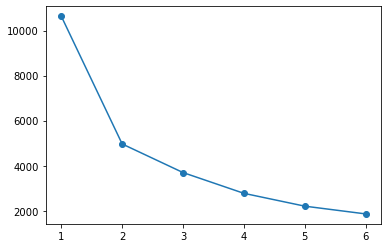

In [24]:
err    = []                      # wcss (within cluster sum square)     # inertia       # total spread

for k in range(1,7):
    
    KM  =  KMeans ( k , n_init =5 , max_iter =1000 , random_state =2 )
    KM.fit(df)            
    err.append    ( KM.inertia_  ) 
    
    
plt.plot  ( range(1,7)  , err  , marker='o') ;

### **2.1.3 - Silhouette Score**

In [25]:
from   sklearn.metrics   import  silhouette_score

In [26]:
scores = []

for k in range(2,7):                                                               

    KM     =  KMeans (n_clusters =k , random_state =2)
    
    labels =  KM.fit_predict (df)

    avg    =  silhouette_score ( df , labels )
    
    scores.append ( {'k':k , 'Avg Silhouette Score':avg} )

In [27]:
table = pd.DataFrame (scores)

table.sort_values ( 'Avg Silhouette Score' , ascending=0 )  .head()    .style.hide_index()

k,Avg Silhouette Score
2,0.445345
4,0.368571
5,0.361723
6,0.361499
3,0.353798


### **2.1.4 - Dendrogram**

In [28]:
from sklearn.cluster          import  AgglomerativeClustering 
from scipy.cluster.hierarchy  import  dendrogram, linkage

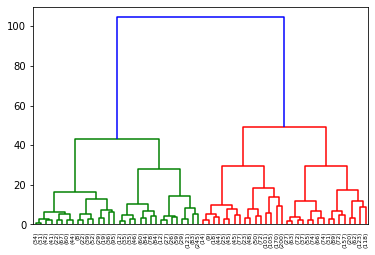

In [29]:
model  =  AgglomerativeClustering  (affinity ='euclidean' ,  linkage ='ward')

model.fit (df)

Z = linkage (df , 'ward')

dendrogram ( Z  ,  p=5  ,  truncate_mode='level')                                                  

plt.show()

<a id='section_4'></a>
## **2.2 - Using best K**

| Method | Best K |
| ---    | ---    |
| Elbow  | 2 |         
| Silhouette | 2 |
| Dendrogram | 2 |

In [30]:
KM    =  KMeans ( n_clusters=2 )  .fit (df)     

<a id='section_5'></a>
## **2.3 - Cluster labelling of records**

In [31]:
labels      =  KM.predict (df)                                        

df["cluster"] =  labels

<a id='section_6'></a>
## **2.4 - Viewing Clusters**

### **2.4.1 - Pairplot**

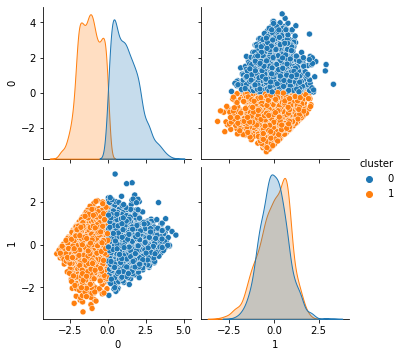

In [32]:
sns.pairplot ( df , diag_kind ='kde' , hue='cluster' ) ;

### **2.4.2 - Boxplot**

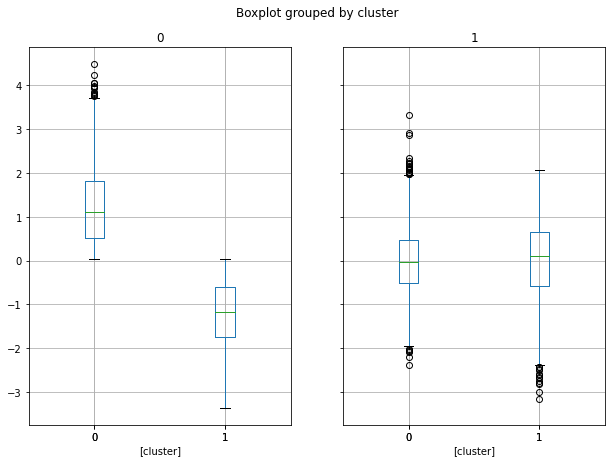

In [33]:
df.boxplot (by='cluster', figsize=(10,7))

plt.show()

### **2.4.3 Scatterplot**

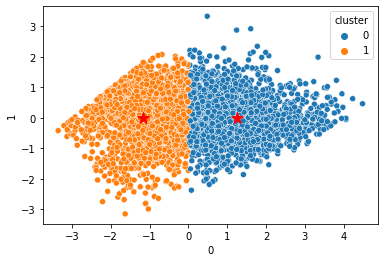

In [34]:
sns.scatterplot ( x= df[0] ,  y = df[1]  ,  hue = 'cluster' , data=df )  

plt.scatter ( x = KM.cluster_centers_[:, 0] , y = KM.cluster_centers_[:, 1] , s=150 , c='red' , marker='*' )

plt.show()

<a id='section_7'></a>
# **3 - Inference from Clusters**

| Label | Signifies |
| ---    | ---    |
| 0  | Low RFM customers |         
| 1 |  High RFM customers |